In [1]:
# ruff: noqa: F401

In [2]:
%load_ext autoreload
%load_ext pyinstrument

%autoreload 2

In [3]:
import sys

sys.path.insert(0, "..")

In [4]:
from datetime import datetime, timedelta
from pathlib import Path

import hvplot.polars
import numpy as np
import polars as pl

In [5]:
from tsdb_benchmarks.monetdb import MonetDB
from tsdb_benchmarks.monetdb.fetch import fetch_binary, fetch_pymonetdb
from tsdb_benchmarks.monetdb.insert import insert
from tsdb_benchmarks.monetdb.utils import drop_table

db = MonetDB()

In [6]:
df = pl.read_parquet("../data/input/data_0.2M_0.5k.parquet").with_columns(
    (100 * pl.col.col_1 - 50).cast(pl.Int8).alias("col_1_int8"),
    (100 * pl.col.col_1 - 50).cast(pl.Int16).alias("col_1_int16"),
    (100 * pl.col.col_1 - 50).cast(pl.Int32).alias("col_1_int32"),
    (100 * pl.col.col_1 - 50).cast(pl.Int64).alias("col_1_int64"),
    pl.col.col_1.cast(pl.Float32).alias("col_1_float32"),
    pl.col.col_1.cast(pl.Float64).alias("col_1_float64"),
    pl.col.col_1.cast(pl.String).alias("col_1_str"),
    (pl.col.col_1 > 0.5).cast(pl.Boolean).alias("col_1_bool"),
    pl.col.col_1.cast(pl.Binary).alias("col_1_blob"),
    ('{ "val": ' + pl.col.col_1.cast(pl.String) + "}").alias("col_1_json"),
    pl.col.time.cast(pl.Time).alias("time_time"),
    pl.col.time.cast(pl.Date).alias("time_date"),
)


df = df.with_columns(
    pl.when((pl.col.time > df.get_column("time")[4]) | (pl.col.time == df.get_column("time")[0]))
    .then(pl.col(n))
    .otherwise(None)
    for n in df.columns
    if n != "time"
)

df = df.select([n for n in df.columns if n == "time" or n.count("_") == 2])

df

time,col_1_int8,col_1_int16,col_1_int32,col_1_int64,col_1_float32,col_1_float64,col_1_str,col_1_bool,col_1_blob,col_1_json
datetime[ms],i8,i16,i32,i64,f32,f64,str,bool,binary,str
2024-08-15 02:41:00,2,2,2,2,0.524554,0.524554,"""0.52455395""",true,"b""0.52455395""","""{ ""val"": 0.52455395}"""
2024-08-15 02:42:00,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:43:00,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:44:00,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:45:00,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…
2024-12-31 23:56:00,-35,-35,-35,-35,0.140222,0.140222,"""0.14022161""",false,"b""0.14022161""","""{ ""val"": 0.14022161}"""
2024-12-31 23:57:00,5,5,5,5,0.551554,0.551554,"""0.55155426""",true,"b""0.55155426""","""{ ""val"": 0.55155426}"""
2024-12-31 23:58:00,21,21,21,21,0.718039,0.718039,"""0.71803874""",true,"b""0.71803874""","""{ ""val"": 0.71803874}"""


In [7]:
drop_table("test_insert", db.connect())

/Users/williamlauren/repos/tsdb-benchmarks/.venv/lib/python3.12/site-packages/sqlalchemy_monetdb/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
insert(df, "test_insert", db.connect(), primary_key="time", json_columns="col_1_json")

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:53:05  Samples:  387
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.777     CPU time: 0.384
/   _/                      v5.0.2

Cell [9]

0.776 <module>  /var/folders/wt/2s8cn3zn1nndhbq08y2cjm500000gn/T/ipykernel_82871/3424466494.py:1
`- 0.773 insert  tsdb_benchmarks/monetdb/insert.py:168
   |- 0.384 Connection.execute  pymonetdb/sql/connections.py:213
   |     [28 frames hidden]  pymonetdb, <built-in>
   |        0.286 socket.recv_into  <built-in>
   |- 0.350 write_binary_column_data  tsdb_benchmarks/monetdb/insert.py:135
   |  |- 0.143 write_string_column  tsdb_benchmarks/monetdb/insert.py:54
   |  |  |- 0.055 [self]  tsdb_benchmarks/monetdb/insert.py
   |  |  |- 0.032 BufferedWriter.write  <built-in>
   |  |  |- 0.031 str.encode  <built-in>
   |  |  `- 0.024 Series.__iter__  polars/series/series.py:1336
   |  |- 0.103 write_datetime_column  tsdb_benchmarks/monetdb/insert.py:85
   |  |  |- 0.044 [self]  tsdb_benchmarks/monetdb/insert.py
   |  |  |- 0.028 Series.__iter__  polars/series/series.py:1336
   |  |  |     [2 frames hidden]  polars, <built-in>
   |  |  |- 0.018 pack  <built-in>
   |  |  `- 0.013 BufferedWriter.write  <built-in>
   |  `- 0.099 write_binary_column  tsdb_benchmarks/monetdb/insert.py:125
   |     |- 0.052 [self]  tsdb_benchmarks/monetdb/insert.py
   |     |- 0.016 BufferedWriter.write  <built-in>
   |     |- 0.014 int.to_bytes  <built-in>
   |     `- 0.009 Series.__iter__  polars/series/series.py:1336
   `- 0.033 Connection.commit  pymonetdb/sql/connections.py:177
         [9 frames hidden]  pymonetdb, <built-in>
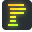

In [9]:
%%pyinstrument

drop_table("test_insert", db.connect())
insert(df, "test_insert", db.connect(), primary_key="time", json_columns="col_1_json")

* JSON is read differently by binary and pymonetdb due to a bug in pymonetdb (ignore `col_1_json`)


In [10]:
fetch_pymonetdb("select * from test_insert order by time", db.connect()).drop("col_1_json").equals(
    fetch_binary("select * from test_insert order by time", db.connect()).drop("col_1_json")
)

/Users/williamlauren/repos/tsdb-benchmarks/notebooks/../tsdb_benchmarks/monetdb/fetch.py:198: PolarsInefficientMapWarning: 
Series.map_elements is significantly slower than the native series API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - s.map_elements(json.loads)
with this one instead:
  + s.str.json_decode()

  return s.map_elements(json.loads, pl.Object)


True

In [11]:
fetch_binary("select * from test_insert order by time", db.connect()).drop("col_1_json").equals(
    df.drop("col_1_json").sort("time")
)

True